In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms 
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import sys
import json

In [17]:
def return_labeled_data_color():
    TARGET_NO_MASK_DIR="../images_color_transformed_no_mask"
    TARGET_MASK_DIR="../images_color_transformed_mask"
    # no mask
    data_list = []
    target_list = []
    for filename in os.listdir(TARGET_NO_MASK_DIR):
        img = cv2.imread(f'{TARGET_NO_MASK_DIR}/{filename}')
        data_list.append(img)
        target_list.append(0.0)
        
    # mask
    for filename in os.listdir(TARGET_MASK_DIR):
        img = cv2.imread(f'{TARGET_MASK_DIR}/{filename}')
        data_list.append(img)
        target_list.append(1.0)
    return data_list, target_list

In [18]:
def return_labeled_data_gray():
    TARGET_NO_MASK_DIR="../images_gray_transformed_no_mask"
    TARGET_MASK_DIR="../images_gray_transformed_mask"
    # no mask
    data_list = []
    target_list = []
    for filename in os.listdir(TARGET_NO_MASK_DIR):
        img = cv2.imread(f'{TARGET_NO_MASK_DIR}/{filename}', cv2.IMREAD_GRAYSCALE)
        data_list.append(img)
        target_list.append(0.0)
        
    # mask
    for filename in os.listdir(TARGET_MASK_DIR):
        img = cv2.imread(f'{TARGET_MASK_DIR}/{filename}', cv2.IMREAD_GRAYSCALE)
        data_list.append(img)
        target_list.append(1.0)
    return data_list, target_list

In [19]:
data_raw, target_raw = return_labeled_data_gray()

In [28]:
data_raw, target_raw = return_labeled_data_color()

In [20]:
class MaskDataSet(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = torch.tensor(y)
        self.n = len(self.y)
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.X[index], self.y[index]
        if self.transform:
            x = self.transform(x)
        return x,y
            
    def __len__(self):
        return self.n

img_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0), (1))])
dataset = MaskDataSet(data_raw, target_raw, transform=img_transform)

In [21]:
BATCH_SIZE = 20

In [22]:
total_idxs = np.random.permutation(np.arange(0, len(dataset), 1))
split_val_idx = int(np.floor(len(total_idxs)*0.7))
split_test_idx = int(np.floor(len(total_idxs)*0.8))
train_idxs, val_idxs, test_idxs = total_idxs[:split_val_idx], total_idxs[split_val_idx:split_test_idx], total_idxs[split_test_idx:]

train_sampler = SubsetRandomSampler(train_idxs)
val_sampler = SubsetRandomSampler(val_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

train_load = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_load = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
test_load = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, sampler=test_sampler, shuffle=False)

In [23]:
def sigmoid(x):
    return torch.exp(x)/(1+torch.exp(x))

class MaskCNNGray(nn.Module):
    def __init__(self, N):
        super(MaskCNNGray, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(8*16*16, 256)
        self.linear2 = nn.Linear(256, 1)
        
    def forward(self, x):
        out = self.pool(F.relu(self.conv1(x)))
        out = out.view(-1, 8*16*16)
        out = F.relu(self.linear1(out))
        return sigmoid(self.linear2(out))

In [24]:
class MaskCNNColor(nn.Module):
    def __init__(self, N):
        super(MaskCNNColor, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(8*16*16, 256)
        self.linear2 = nn.Linear(256, 1)
        
    def forward(self, x):
        out = self.pool(F.relu(self.conv1(x)))
        out = out.view(-1, 8*16*16)
        out = F.relu(self.linear1(out))
        return sigmoid(self.linear2(out))

In [25]:
# Seems that the data is linearly seperable!!
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear1 = nn.Linear(34*34, 256)
        self.linear2 = nn.Linear(256, 1)
        
    def forward(self, x):
        out = x.view(-1, 34*34)
        out = self.linear1(out)
        return F.sigmoid(self.linear2(out))
    

### Model Training
- Train the grayscale model or color model depending on which dataset was loaded

In [39]:
EPOCHS = 100
IMAGE_DIM = 34
model = MaskCNNGray(IMAGE_DIM)
# model = MaskCNNColor(IMAGE_DIM)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [40]:
# train loop
train_loss = []
val_loss = []
val_loss_min = sys.maxsize

for epoch in range(EPOCHS):
    training_loss = 0
    train_size = 0
    validation_loss = 0
    validation_size = 0
    
    model.train()
    for images, labels in train_load:
#         images, labels = images.to(device), labels.to(device)
        # train
        labels = labels.view(len(labels), -1)
        optimizer.zero_grad()
        out = model.forward(images)

        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss
        train_size += len(images)
        # .item()
    
    model.eval()
    for images, labels in val_load:
        # images, labels = images.to(device), labels.to(device)
        labels = labels.view(len(labels), -1)
        optimizer.zero_grad()
        out = model.forward(images)
        loss = criterion(out, labels)
        validation_loss += loss
        validation_size += len(images)
        # .item()
    
    t_loss = training_loss
    v_loss = validation_loss
    train_loss.append(t_loss.item())
    val_loss.append(v_loss.item())
    
    print(f"EPOCH:{epoch} - Training Loss: {t_loss} - Validation Loss: {v_loss}")
    if v_loss < val_loss_min:
        print(f"Validation Loss Decreased From {val_loss_min} => {v_loss}")
        val_loss_min = v_loss

EPOCH:0 - Training Loss: 10.343568801879883 - Validation Loss: 2.073237180709839
Validation Loss Decreased From 9223372036854775807 => 2.073237180709839
EPOCH:1 - Training Loss: 10.250484466552734 - Validation Loss: 2.0523040294647217
Validation Loss Decreased From 2.073237180709839 => 2.0523040294647217
EPOCH:2 - Training Loss: 10.157368659973145 - Validation Loss: 1.994253158569336
Validation Loss Decreased From 2.0523040294647217 => 1.994253158569336
EPOCH:3 - Training Loss: 10.066155433654785 - Validation Loss: 1.968820571899414
Validation Loss Decreased From 1.994253158569336 => 1.968820571899414
EPOCH:4 - Training Loss: 9.986722946166992 - Validation Loss: 2.0577950477600098
EPOCH:5 - Training Loss: 9.881986618041992 - Validation Loss: 2.058774948120117
EPOCH:6 - Training Loss: 9.712321281433105 - Validation Loss: 2.030158281326294
EPOCH:7 - Training Loss: 9.564886093139648 - Validation Loss: 1.8144593238830566
Validation Loss Decreased From 1.968820571899414 => 1.814459323883056

EPOCH:80 - Training Loss: 0.5281020402908325 - Validation Loss: 0.7442758083343506
EPOCH:81 - Training Loss: 0.5016749501228333 - Validation Loss: 0.14842751622200012
Validation Loss Decreased From 0.1703324317932129 => 0.14842751622200012
EPOCH:82 - Training Loss: 0.4574525058269501 - Validation Loss: 0.2233348786830902
EPOCH:83 - Training Loss: 0.43618643283843994 - Validation Loss: 0.19917504489421844
EPOCH:84 - Training Loss: 0.42974385619163513 - Validation Loss: 0.23950441181659698
EPOCH:85 - Training Loss: 0.4066448509693146 - Validation Loss: 0.1916821151971817
EPOCH:86 - Training Loss: 0.4107075035572052 - Validation Loss: 0.23943226039409637
EPOCH:87 - Training Loss: 0.4024044871330261 - Validation Loss: 0.33574584126472473
EPOCH:88 - Training Loss: 0.4842630624771118 - Validation Loss: 0.1340702921152115
Validation Loss Decreased From 0.14842751622200012 => 0.1340702921152115
EPOCH:89 - Training Loss: 0.42792826890945435 - Validation Loss: 0.21537376940250397
EPOCH:90 - Trai

In [45]:
# test loop
n_samples = 0
n_correct = 0
classified_correct = []
classified_incorrect = []
confusion_matrix = np.zeros((2,2))

model.eval()
for images, labels in test_load:
#     images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    preds = torch.round(model(images))
    preds, labels = preds.detach().numpy(), labels.detach().numpy()
    n_samples += len(preds)
    n_correct += len((preds == labels))
    # .item()
    for i in range(2):
        idxs = np.arange(0, len(preds), 1)[labels==i]
        for ind in idxs:
            confusion_matrix[i][int(preds[ind])] += 1
            if preds[ind] == i:
                classified_correct.append([images[ind], preds[ind]])
            else:
                classified_incorrect.append([images[ind], preds[ind]])

In [46]:
print(f"Model Accuracy: {(n_correct/n_samples)*100}")

Model Accuracy: 100.0


In [47]:
print(confusion_matrix)

[[35.  1.]
 [ 1. 45.]]


In [49]:
def predict(model, img):
    copy = img.copy()
    model.eval()
    optimizer.zero_grad()
    trans = img_transform(img)
    trans = trans.view(-1, *list(trans.shape))
    out = torch.round(model.forward(trans))
    pred = 'No Mask' if out == 0 else 'Mask'
    print(pred)
    plot_image(copy)

In [51]:
def plot_image(img):
    fig = plt.figure(figsize=(10,8))
    plt.imshow(img, cmap='gray')
    plt.show()

No Mask


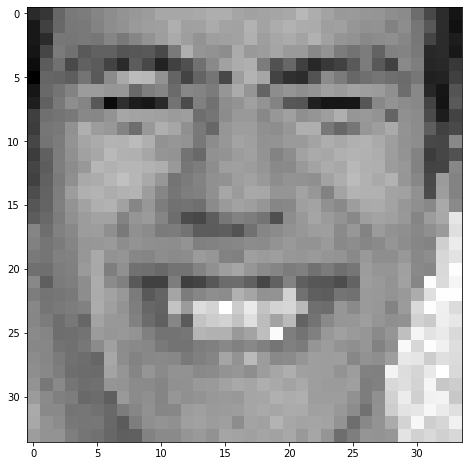

In [56]:
predict(model, data_raw[45])

Mask


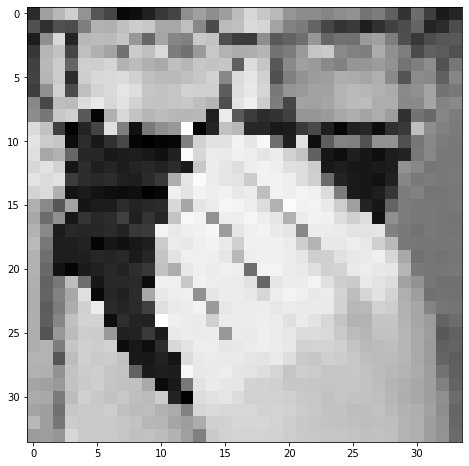

In [54]:
predict(model, data_raw[250])

### Viewing Grayscale CNN Kernels
- Usually first layer kernels learn detailed feature extractions, but the kernels below don't seem to reflect this. This may be due to the fact that my kernel sizes aren't large enough to resonably display edge detectors like I was hoping...

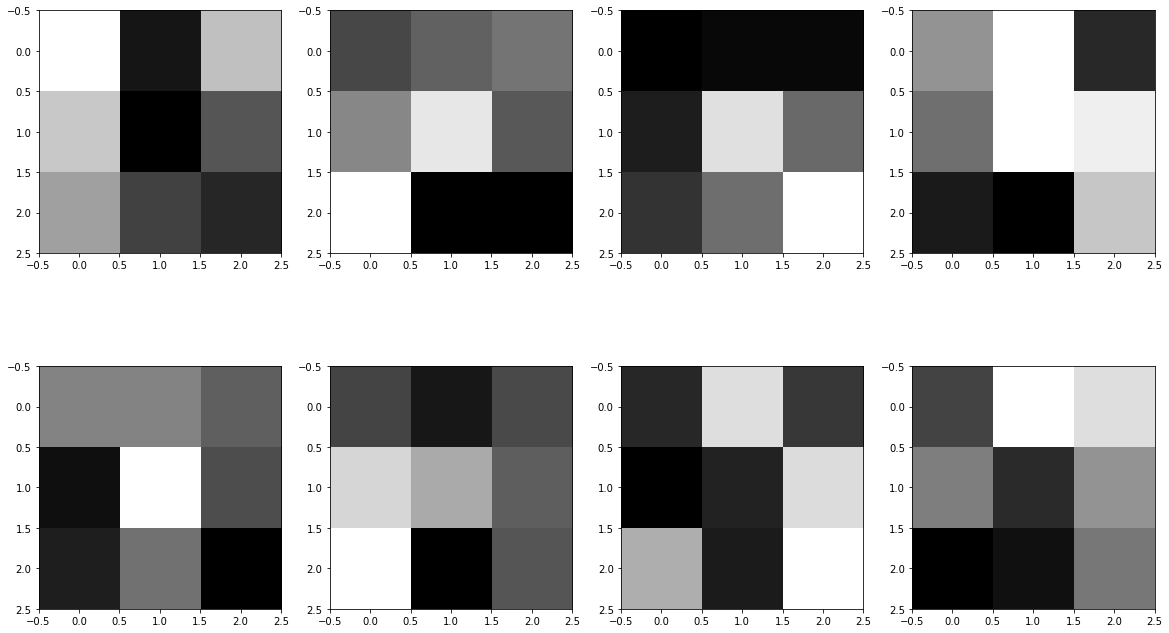

In [57]:
weights = []
for i in range(len(model.conv1.weight)):
    weights.append(model.conv1.weight[i].detach().numpy()[0])
    
fig,axes = plt.subplots(2,4,figsize=(20,12))
for i in range(2):
    for j in range(4):
        axes[i][j].imshow(weights[i*4+j], cmap='gray')